## One Model

rosshandler: https://pubmed.ncbi.nlm.nih.gov/37982461/ \
nowotschin: https://pubmed.ncbi.nlm.nih.gov/30959515/ \
https://www.nature.com/articles/s41592-021-01336-8 \
https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/harmonization.html \
https://rapids-singlecell.readthedocs.io/en/latest/notebooks/demo_gpu-seuratv3-brain-1M.html 

In [1]:
%%time
# importing our library 
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import torch
import os
import scipy
from scipy.io import mmread
from scipy.io import mmwrite
import anndata as ad
import psutil
import h5py
import rapids_singlecell as rsc
import jax
import matplotlib
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import seaborn as sns
from plotly.validators.scatter.marker import SymbolValidator
from plotly import graph_objects as go

Global seed set to 0
/home/schroel1/miniconda3/envs/gpu2/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/schroel1/miniconda3/envs/gpu2/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


CudaAPIError: [46] Call to cuDevicePrimaryCtxRetain results in CUDA_ERROR_DEVICE_UNAVAILABLE

## Memory

In [2]:
## RAM info

# Get information about virtual memory usage
virtual_mem = psutil.virtual_memory()
# Access attributes like total, available, and used memory
total_mem = virtual_mem.total  # Total memory in bytes
available_mem = virtual_mem.available  # Available memory in bytes
used_mem = virtual_mem.used  # Used memory in bytes
# You can also calculate memory usage percentage
percent_used = used_mem / total_mem * 100

# printing it out
print(f"Total Memory: {total_mem / (1024**3)} GB")
print(f"Available Memory: {available_mem / (1024**3)} GB")
print(f"Used Memory: {used_mem / (1024**3)} GB")
print(f"Memory Usage Percentage: {percent_used:.2f}%")

Total Memory: 1007.155345916748 GB
Available Memory: 956.5990333557129 GB
Used Memory: 48.582000732421875 GB
Memory Usage Percentage: 4.82%


## Cuda, torch and jax setup

In [3]:
!nvidia-smi

Tue Nov  5 14:17:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                     On  | 00000000:E3:00.0 Off |                    0 |
|  0%   37C    P0              82W / 300W |    273MiB / 46068MiB |      0%   E. Process |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
print(torch.version.cuda)
use_cuda = torch.cuda.is_available()
use_cuda

11.8


True

In [5]:
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

__CUDNN VERSION: 90100
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA A40
__CUDA Device Total Memory [GB]: 47.622258688


In [6]:
## trading of performance for accuracy, can be set to `medium` `high` `highest`
torch.set_float32_matmul_precision('high')

In [7]:
print(torch.backends.cudnn.version())

90100


In [8]:
jax.default_backend()

'gpu'

## SETTING PATH

In [9]:
data_path = '/data/hadjantalab/lucas/atlas/data'

## LOADING COMPLETE DATASET AND SUBSETTING

In [10]:
file_path = os.path.join(data_path, 'adata.h5ad')
adata = ad.read_h5ad(file_path)
adata

AnnData object with n_obs × n_vars = 535935 × 8342
    obs: 'batch', 'stage', 'sample', 'covariate_composite', 'celltype_nowotschin', 'celltype_rosshandler', 'celltype_pijuansala', 'nowotschin_cluster', 'rosshandler_somite_count', 'rosshandler_anatomy', 'rosshandler_phase', 'rosshandler_S_score', 'rosshandler_G2M_score', 'rosshandler_louvain', 'rosshandler_leiden', 'annotation', 'mt-Atp6', 'mt-Atp8', 'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'colormap_annotation', 'colormap_batch', 'colormap_rosshandler', 'colormap_stage', 'log1p', 'neighbors_scVI', 'phase_colors', 'symbolmap_batch', 'symbolmap_plotly_batch', 'symbolmap_plotly_stage', 'symbolmap_stage', 'umap'
    obsm: 'X_scVI', 'X_umap', 'X_umap_scVI', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'log_no

In [15]:
with pd.option_context('display.max_rows', None):
  print(adata.obs['celltype_rosshandler'].value_counts().sort_index())

Allantois                                           8515
Allantois endothelium                               2689
Amniotic ectoderm                                   3140
Anterior Primitive Streak                           1787
Anterior cardiopharyngeal progenitors               1698
Anterior somitic tissues                            3784
Blood progenitors                                   2642
Branchial arch neural crest                         7303
Cardiomyocytes FHF 1                                2619
Cardiomyocytes FHF 2                                2505
Cardiomyocytes SHF 1                                2023
Cardiomyocytes SHF 2                                1990
Cardiopharyngeal progenitors                        1530
Cardiopharyngeal progenitors FHF                    3058
Cardiopharyngeal progenitors SHF                    5151
Caudal epiblast                                     3674
Caudal mesoderm                                     3310
Chorioallantoic-derived erythro

In [16]:
with pd.option_context('display.max_rows', None):
  print(adata.obs['celltype_nowotschin'].value_counts().sort_index())

Blood                      1898
EPI                        8969
Endothelial                 987
GermCells                   226
Gut tube                   1823
Gut tube:DE:Colon            28
Gut tube:DE:Liver           190
Gut tube:DE:Lung           2443
Gut tube:DE:Pancreas        511
Gut tube:DE:Small int       901
Gut tube:DE:Thymus         3443
Gut tube:DE:Thyroid        1255
Gut tube:VE:Colon          2414
Gut tube:VE:Liver          1207
Gut tube:VE:Lung            930
Gut tube:VE:Pancreas       5291
Gut tube:VE:Small int      2700
Gut tube:VE:Thymus          154
Gut tube:VE:Thyroid          11
ICM                         268
Mes                       20248
Midline                    1425
PrE                         409
TE                          741
YsE                        8837
ExE                        4936
ParE                      11289
VE                           40
emVE                       6339
exVE                      19584
DE                         3554
unknown 

In [17]:
populations_of_interest_ross = [
    'ExE endoderm', 
    'Pharyngeal endoderm',
    'Midgut',
    'Foregut',
    'Hindgut',
    'Visceral endoderm',
    'Parietal endoderm',
    'Gut tube',
    'Thyroid primordium',
    'Anterior Primitive Streak'
    ]
populations_of_interest_nowo = [
    'exVE',
    'ParE',
    'emVE',
    'DE',
    'PrE',
    'VE',
    'Gut tube',
    'Gut tube:VE:Pancreas',
    'Gut tube:DE:Thymus', 
    'Gut tube:VE:Small int', 
    'Gut tube:DE:Lung', 
    'Gut tube:VE:Colon ',
    'Gut tube:DE:Thyroid', 
    'Gut tube:VE:Liver', 
    'Gut tube:VE:Lung',
    'Gut tube:DE:Small int', 
    'Gut tube:DE:Pancreas', 
    'Gut tube:DE:Liver',
    'Gut tube:VE:Thymus',
    'Gut tube:DE:Colon', 
    'Gut tube:VE:Thyroid'
]

In [18]:
adata[adata.obs['batch'] == 'nowotschin'].obs['stage'].value_counts()

E8.75    57401
E7.5     33850
E5.5     11550
E6.5      9244
E3.5       774
E4.5       232
Name: stage, dtype: int64

In [19]:
adata[adata.obs['batch'] == 'pijuan-sala'].obs['stage'].value_counts()

E8.5     16909
E8.0     16681
E8.25    15935
E7.0     14749
E7.75    14493
E7.25    13537
E7.5     10994
E6.5      3484
E6.75     2075
Name: stage, dtype: int64

In [20]:
adata[adata.obs['batch'] == 'rosshandler'].obs['stage'].value_counts()

E9.0     93020
E9.25    71303
E8.75    68910
E8.5     41163
E9.5     39631
Name: stage, dtype: int64

In [21]:
## extracting only the above defined celltypes
mask_populations = (adata.obs['celltype_rosshandler'].isin(populations_of_interest_ross)) | (adata.obs['celltype_nowotschin'].isin(populations_of_interest_nowo))
adata = adata[mask_populations,:].copy()

In [23]:
## stages to keep
stages = ['E5.5', 'E6.5', 'E6.75', 'E7.0', 'E7.25', 'E7.5', 'E7.75']
mask_stages = adata.obs['stage'].isin(stages)
adata = adata[mask_stages,:].copy()

In [24]:
adata.obs['batch'].value_counts().sort_index()

pijuan-sala    10423
nowotschin     31244
Name: batch, dtype: int64

In [25]:
adata.obs['stage'].value_counts().sort_index()

E5.5      1107
E6.75      323
E7.75     2602
E7.25     2470
E7.0      2484
E6.5      7371
E7.5     25310
Name: stage, dtype: int64

In [29]:
adata.obs['celltype_nowotschin'].value_counts()

exVE       19584
unknown    10423
emVE        6339
DE          3554
ParE        1727
VE            40
Name: celltype_nowotschin, dtype: int64

## scVI Model

In [27]:
## hyperparameters inferred from hyperparameter tuning
n_hidden = 256
n_layers = 1
n_latent = 45
lr = 0.0032
## n_epochs from https://github.com/theislab/scib-reproducibility/blob/main/notebooks/integration/scanvi.ipynb
n_epochs = np.min([round((20000/adata.n_obs)*400), 400]) ## can not be passed, but this will be used as n_epochs
print(f'Anticipated number of epochs: {n_epochs}') 
batch_size = 148 ## batch_size=128 made my model crash for some reason

Anticipated number of epochs: 192


In [28]:
obs_continuous_covariates = [
    'mt-Atp6',
    'mt-Atp8',
    'mt-Co1',
    'mt-Co2',
    'mt-Co3',
    'mt-Cytb',
    'mt-Nd1',
    'mt-Nd2',
    'mt-Nd3',
    'mt-Nd4',
    'mt-Nd4l',
    'mt-Nd5',
    'mt-Nd6',
    'S_score',
    'G2M_score',
]

In [29]:
%%time
scvi.model.SCVI.setup_anndata(adata, 
                              batch_key="batch", 
                              categorical_covariate_keys = ['sample', 'stage'],
                              continuous_covariate_keys = obs_continuous_covariates)

/home/schroel1/miniconda3/envs/gpu2/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


CPU times: user 67.3 ms, sys: 127 ms, total: 194 ms
Wall time: 1.11 s


In [30]:
%%time
model = scvi.model.SCVI(adata, n_hidden=n_hidden, n_layers=n_layers, n_latent=n_latent, gene_likelihood="nb")

CPU times: user 177 ms, sys: 64 ms, total: 241 ms
Wall time: 814 ms


In [27]:
#model.view_anndata_setup()

In [31]:
print(f"adata UUID (assigned by setup_anndata): {adata.uns['_scvi_uuid']}")
print(f"AnnDataManager: {model._setup_adata_manager_store[adata.uns['_scvi_uuid']]}")
print(model.get_anndata_manager(adata))
model.__class__
## https://docs.scvi-tools.org/en/stable/tutorials/notebooks/dev/model_user_guide.html 
## https://anndata.readthedocs.io/en/latest/tutorials/notebooks/annloader.html 

adata UUID (assigned by setup_anndata): 1f99ce07-18cf-4f83-97da-a05da44b2588
AnnDataManager: <scvi.data._manager.AnnDataManager object at 0x2ad589759330>


scvi.model._scvi.SCVI

In [32]:
%%time
model.train(plan_kwargs={"lr": lr}, 
            batch_size = batch_size, 
            validation_size = 0.1,
            check_val_every_n_epoch = 1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/192:   0%|          | 0/192 [00:00<?, ?it/s]

/home/schroel1/miniconda3/envs/gpu2/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 192/192: 100%|██████████| 192/192 [08:04<00:00,  2.43s/it, loss=3.6e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=192` reached.


Epoch 192/192: 100%|██████████| 192/192 [08:04<00:00,  2.53s/it, loss=3.6e+03, v_num=1]
CPU times: user 8min 58s, sys: 4min 13s, total: 13min 12s
Wall time: 8min 5s


## Latent space / neighbors / leiden / umap

In [33]:
%%time
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

CPU times: user 1.36 s, sys: 1.26 s, total: 2.62 s
Wall time: 1.07 s


In [34]:
%%time
rsc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY, n_neighbors = 60, key_added = 'neighbors_scVI')

CPU times: user 494 ms, sys: 164 ms, total: 658 ms
Wall time: 3.03 s


In [35]:
%%time
rsc.tl.umap(adata, neighbors_key = 'neighbors_scVI', min_dist=0.5, spread = 0.5, n_components = 2, random_state = 66)
adata.obsm['X_umap_scVI'] = adata.obsm['X_umap'].copy()

CPU times: user 223 ms, sys: 196 ms, total: 420 ms
Wall time: 1.24 s


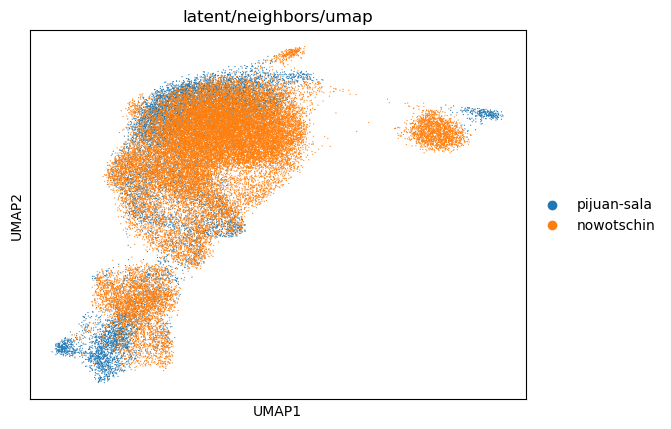

In [36]:
sc.pl.umap(adata, color = 'batch', title = 'latent/neighbors/umap')

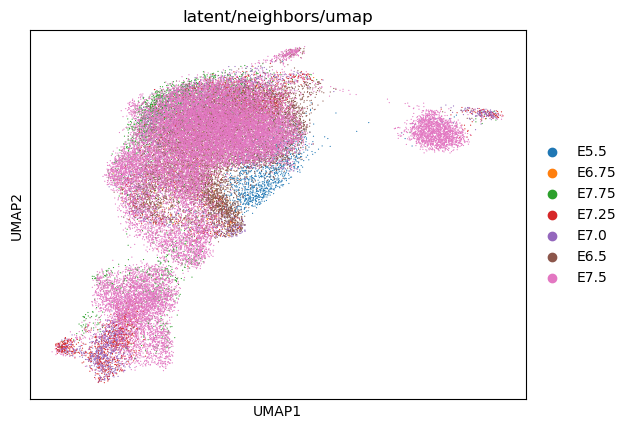

In [37]:
sc.pl.umap(adata, color = 'stage', title = 'latent/neighbors/umap')

## LEIDEN CLUSTERS

In [38]:
resolutions = [round(r * 0.01, 2) for r in range(100, -15, -5)] 

In [39]:
## creating different resolutions for the leiden to pick one with 10-15 clusters

# Define the range of resolutions (1.0 to 0.01 with 0.5 steps)
resolutions = [round(r * 0.01, 2) for r in range(100, -15, -5)]  # [1.0, 0.5, 0.01]

# Perform Leiden clustering for all resolutions and store the cluster labels
for res in resolutions:
    sc.tl.leiden(adata, resolution=res, neighbors_key='neighbors_scVI', key_added=f'leiden_res_{res}', flavor='leidenalg')
    # Store the clustering labels for the current resolution

/scratch/lsftmp/10330835.tmpdir/ipykernel_2076/3166632727.py:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=res, neighbors_key='neighbors_scVI', key_added=f'leiden_res_{res}', flavor='leidenalg')


In [40]:
# List to store the clustering results
cluster_label_list = []

# Loop through each resolution and extract the corresponding cluster labels from adata.obs
for res in resolutions:
    # Extract the clustering labels from adata.obs and append them to the list
    cluster_label_list.append(adata.obs[f'leiden_res_{res}'].values)

In [41]:
## Checking how many clusters per resolution

# Loop through both the resolution and cluster labels at the same time
for res, cluster in zip(resolutions, cluster_label_list):
    # Get unique values and their counts
    unique, counts = np.unique(cluster, return_counts=True)
    # Print the resolution and corresponding cluster counts
    print(f"Resolution: {res}\t\tNumber of clusters {len(unique)}")
    #print(dict(zip(unique, counts)))


Resolution: 1.0		Number of clusters 13
Resolution: 0.95		Number of clusters 12
Resolution: 0.9		Number of clusters 9
Resolution: 0.85		Number of clusters 8
Resolution: 0.8		Number of clusters 8
Resolution: 0.75		Number of clusters 8
Resolution: 0.7		Number of clusters 8
Resolution: 0.65		Number of clusters 8
Resolution: 0.6		Number of clusters 7
Resolution: 0.55		Number of clusters 5
Resolution: 0.5		Number of clusters 5
Resolution: 0.45		Number of clusters 5
Resolution: 0.4		Number of clusters 5
Resolution: 0.35		Number of clusters 5
Resolution: 0.3		Number of clusters 5
Resolution: 0.25		Number of clusters 5
Resolution: 0.2		Number of clusters 5
Resolution: 0.15		Number of clusters 4
Resolution: 0.1		Number of clusters 3
Resolution: 0.05		Number of clusters 3
Resolution: 0.0		Number of clusters 1
Resolution: -0.05		Number of clusters 1
Resolution: -0.1		Number of clusters 1


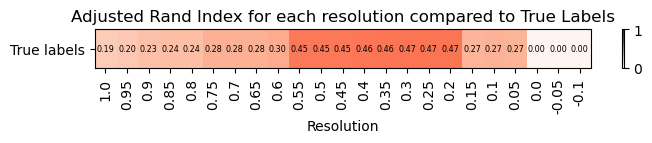

In [42]:
from sklearn.metrics import adjusted_rand_score

# Assuming 'adata' is your AnnData object and 'neighbors_scVI' has been computed
true_labels = adata.obs['celltype_nowotschin'].values

# Now compute the ARI array for all resolutions
ari_scores = np.zeros(len(resolutions))

# Compute ARI for each resolution against the true labels
for j in range(len(resolutions)):
    ari_scores[j] = adjusted_rand_score(true_labels, cluster_label_list[j])

# Plotting the ARI heatmap
fig, ax = plt.subplots(1, 1, figsize=(8, 0.5))
im = ax.imshow(ari_scores.reshape(1, -1), cmap='Reds', vmin=0, vmax=1, aspect='auto')  # Reshape to 1xN for heatmap
fig.colorbar(im, ax=ax)

# Set ticks and labels for the axes
ax.set_xticks(range(len(resolutions)))
ax.set_xticklabels(resolutions, rotation=90)
ax.set_yticks([0])
ax.set_yticklabels(['True labels'])
ax.set_xlabel('Resolution')
ax.set_title('Adjusted Rand Index for each resolution compared to True Labels')

# Add text annotations inside the heatmap rectangles
for j in range(len(resolutions)):  # Iterate over columns (resolutions)
    ax.text(j, 0, f"{ari_scores[j]:.2f}", ha='center', va='center', color='black', fontsize='xx-small')

plt.show()


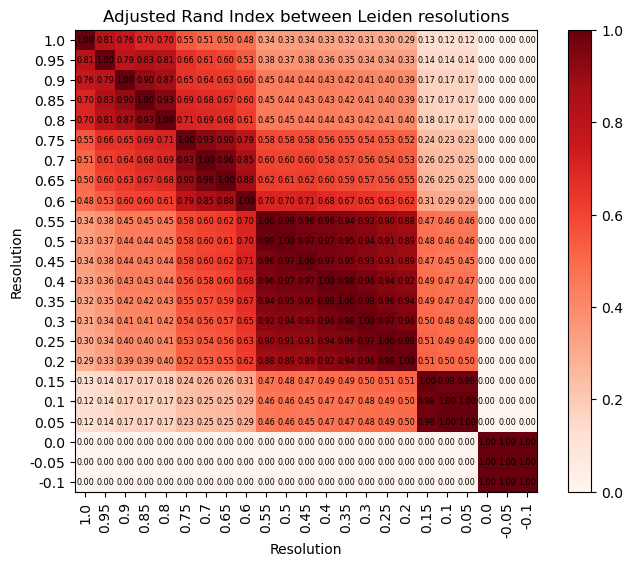

In [43]:
from sklearn.metrics import adjusted_rand_score

# Assume 'adata' is your AnnData object and 'neighbors_scVI' has been computed

# Now compute the ARI matrix for all pairs of resolutions
rand_index_mat = np.zeros((len(resolutions), len(resolutions)))

# Compute ARI for each pair of resolutions
for i in range(len(resolutions)):
    for j in range(len(resolutions)):
        rand_index_mat[i, j] = adjusted_rand_score(cluster_label_list[i], cluster_label_list[j])

# Plotting the ARI heatmap
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
im = ax.imshow(rand_index_mat, cmap='Reds', vmin=0, vmax=1)
fig.colorbar(im, ax=ax)

# Set ticks and labels for the axes
ax.set_xticks(range(len(resolutions)))
ax.set_xticklabels(resolutions, rotation=90)
ax.set_yticks(range(len(resolutions)))
ax.set_yticklabels(resolutions)
ax.set_xlabel('Resolution')
ax.set_ylabel('Resolution')
ax.set_title('Adjusted Rand Index between Leiden resolutions')

# Add text annotations inside the heatmap rectangles
for i in range(len(resolutions)):
    for j in range(len(resolutions)):
        ax.text(j, i, f"{rand_index_mat[i, j]:.2f}", ha='center', va='center', color='black', fontsize = 'xx-small')

plt.show()


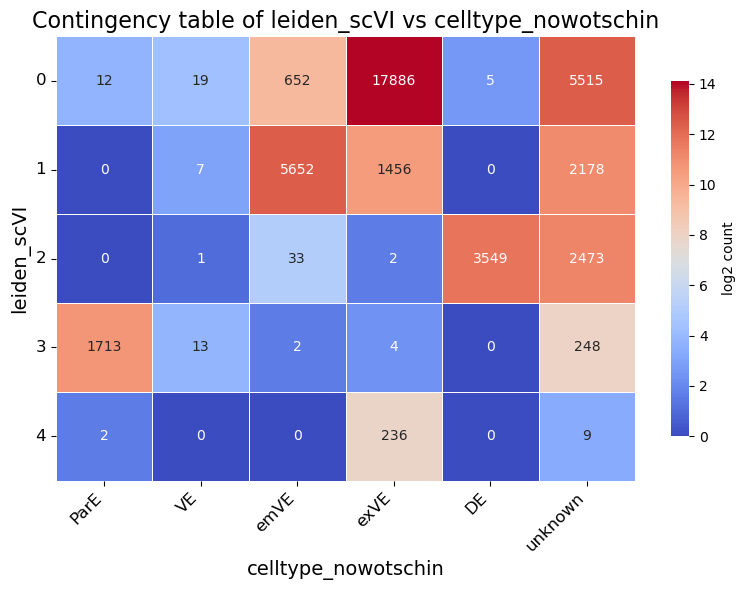

In [70]:

# Step 1: Create the contingency table
contingency_table = pd.crosstab(adata.obs['leiden_res_0.2'], adata.obs['celltype_nowotschin'])

# Step 2: Apply log2 transformation to the counts for the color scale
log2_contingency_table = np.log2(contingency_table + 1)  # Add 1 to avoid log(0) issues

# Step 3: Set the figure size and plot the heatmap
plt.figure(figsize=(8,6))  # Adjust figure size for better readability
heatmap = sns.heatmap(log2_contingency_table, 
                      annot=contingency_table,  # Use raw counts for annotations
                      fmt="d",                  # Format annotations as integers
                      cmap="coolwarm",          # Color map for better contrast
                      linewidths=.5,            # Add gridlines for clarity
                      cbar_kws={'shrink': .8, 'label': 'log2 count'},  # Adjust the color bar size
                      annot_kws={"size": 10})   # Set font size for annotations

# Step 4: Adjust axis labels and title
plt.title('Contingency table of leiden_scVI vs celltype_nowotschin', fontsize=16)
plt.xlabel('celltype_nowotschin', fontsize=14)
plt.ylabel('leiden_scVI', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right", fontsize=12)  # Rotate for better fit
plt.yticks(rotation=0, fontsize=12)               # Keep y-axis labels horizontal

# Step 5: Adjust layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()


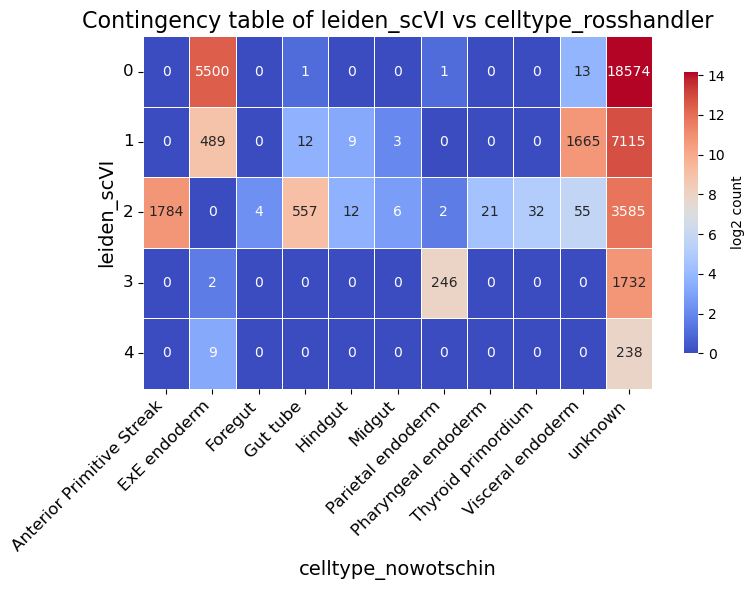

In [71]:

# Step 1: Create the contingency table
contingency_table = pd.crosstab(adata.obs['leiden_res_0.2'], adata.obs['celltype_rosshandler'])

# Step 2: Apply log2 transformation to the counts for the color scale
log2_contingency_table = np.log2(contingency_table + 1)  # Add 1 to avoid log(0) issues

# Step 3: Set the figure size and plot the heatmap
plt.figure(figsize=(8,6))  # Adjust figure size for better readability
heatmap = sns.heatmap(log2_contingency_table, 
                      annot=contingency_table,  # Use raw counts for annotations
                      fmt="d",                  # Format annotations as integers
                      cmap="coolwarm",          # Color map for better contrast
                      linewidths=.5,            # Add gridlines for clarity
                      cbar_kws={'shrink': .8, 'label': 'log2 count'},  # Adjust the color bar size
                      annot_kws={"size": 10})   # Set font size for annotations

# Step 4: Adjust axis labels and title
plt.title('Contingency table of leiden_scVI vs celltype_rosshandler', fontsize=16)
plt.xlabel('celltype_nowotschin', fontsize=14)
plt.ylabel('leiden_scVI', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right", fontsize=12)  # Rotate for better fit
plt.yticks(rotation=0, fontsize=12)               # Keep y-axis labels horizontal

# Step 5: Adjust layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()


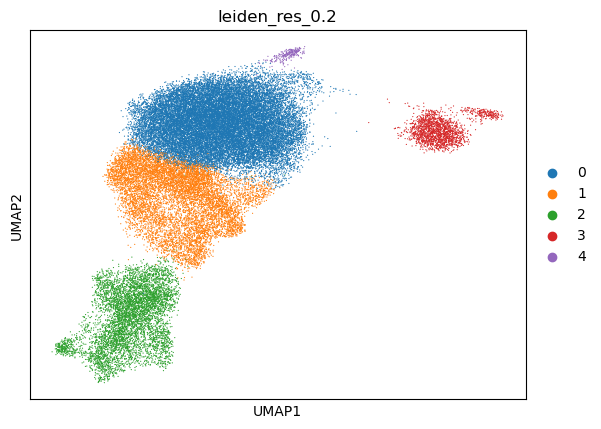

In [78]:
voi = 'leiden_res_0.2'
sc.pl.umap(adata, color = voi, title = voi)

In [79]:
## SETTING THE LEIDEN RESOLUTION THAT WE GONNA USE FOR DGE
adata.obs['leiden_scVI'] = adata.obs['leiden_res_0.2'].copy()

## SIMPLE LABEL TRANSFER VIA NEAREST NEIGHBORS

In [34]:
%%time
## getting the nearest neighbors
SCVI_LATENT_KEY = "X_scVI"
n_neighbors = 100
rsc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY, n_neighbors = n_neighbors, key_added = f'neighbors_{n_neighbors}_scVI')

CPU times: user 293 ms, sys: 178 ms, total: 470 ms
Wall time: 599 ms


In [35]:
from scipy.stats import mode

# Define the subset of interest
mask_subset = adata.obs['batch'] == 'pijuan-sala'

# Define the subset of interest as integer indices
subset_indices = np.where(mask_subset)[0]  # Get integer positions of the subset

# Initialize a list to store the most common annotation for each cell in the subset
nn_transfer = []

## deleting if nn_transfer exists
if 'nn_transfer' in adata.obs:
    del adata.obs['nn_transfer']

# Iterate over the subset of cells using integer indices
for i in subset_indices:
    # Get indices of neighbors for the current cell
    neighbors_indices = adata.obsp[f'neighbors_{n_neighbors}_scVI_connectivities'][i].indices
    # Remove indices of cells from the same batch using np.isin
    neighbors_indices = neighbors_indices[~np.isin(neighbors_indices, subset_indices)]
    
    # Get the annotations for these neighbors
    neighbor_annotations = adata.obs['celltype_nowotschin'].iloc[neighbors_indices]

    if len(neighbor_annotations) == 0: 
        most_common_annotation = 'stays_true_to_batch'
    else:
        # Find the most common annotation among neighbors using pd.Series.mode()
        most_common_annotation = neighbor_annotations.mode().iloc[0]
    
    # Append to the list
    nn_transfer.append(most_common_annotation)

# Add the common annotations to the subset in adata.obs
adata.obs.loc[mask_subset, 'nn_transfer'] = nn_transfer

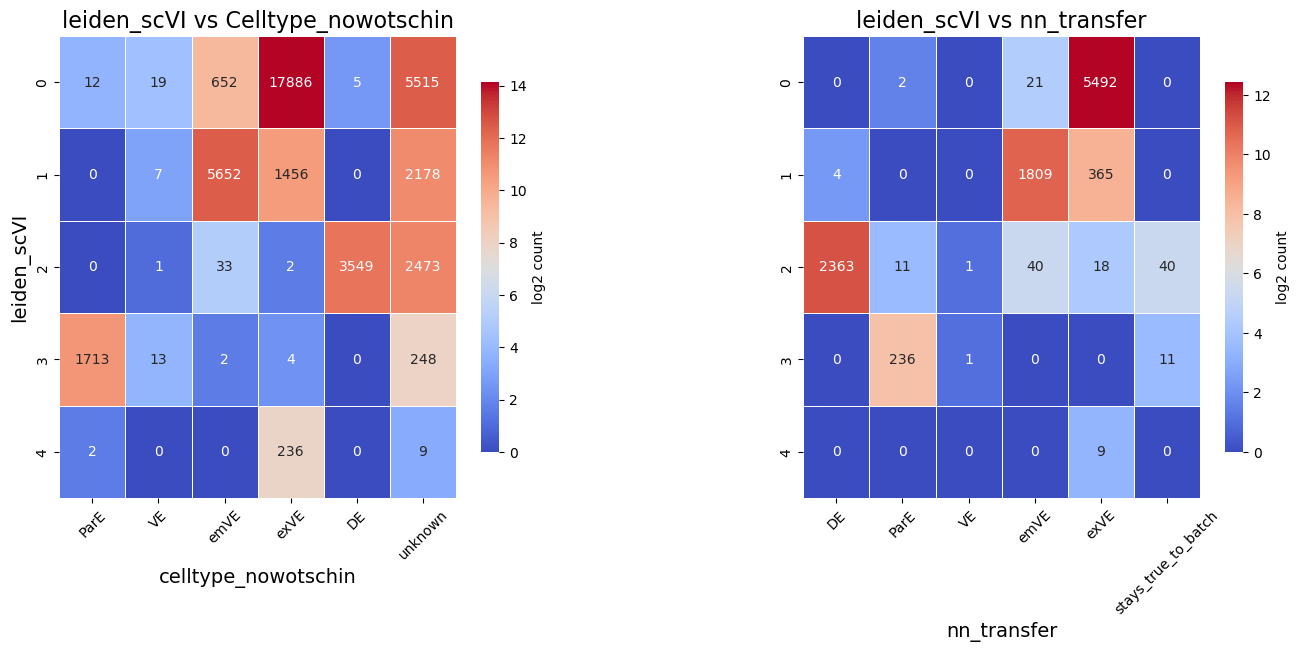

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create contingency tables for both comparisons
contingency_table_1 = pd.crosstab(adata.obs['leiden_scVI'], adata.obs['celltype_nowotschin'])
contingency_table_2 = pd.crosstab(adata.obs['leiden_scVI'], adata.obs['nn_transfer'])

# Step 2: Apply log2 transformation to each contingency table for the color scale
log2_contingency_table_1 = np.log2(contingency_table_1 + 1)  # Add 1 to avoid log(0)
log2_contingency_table_2 = np.log2(contingency_table_2 + 1)

# Step 3: Set up figure and axes for side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'wspace': 0.5})  # Space between subplots

# Plot the first heatmap
sns.heatmap(log2_contingency_table_1, 
            annot=contingency_table_1,  # Use raw counts for annotations
            fmt="d",                    # Format annotations as integers
            cmap="coolwarm",            # Color map for better contrast
            linewidths=.5,              # Add gridlines for clarity
            cbar_kws={'shrink': .8, 'label': 'log2 count'},  # Adjust color bar
            annot_kws={"size": 10},
            ax=axes[0])                 # Plot on first subplot

# Adjust labels and title for the first heatmap
axes[0].set_title('leiden_scVI vs Celltype_nowotschin', fontsize=16)
axes[0].set_xlabel('celltype_nowotschin', fontsize=14)
axes[0].set_ylabel('leiden_scVI', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Plot the second heatmap
sns.heatmap(log2_contingency_table_2, 
            annot=contingency_table_2,  # Use raw counts for annotations
            fmt="d",                    # Format annotations as integers
            cmap="coolwarm",            # Use same color map for consistency
            linewidths=.5,              # Add gridlines for clarity
            cbar_kws={'shrink': .8, 'label': 'log2 count'},  # Adjust color bar
            annot_kws={"size": 10},
            ax=axes[1])                 # Plot on second subplot

# Adjust labels and title for the second heatmap
axes[1].set_title('leiden_scVI vs nn_transfer', fontsize=16)
axes[1].set_xlabel('nn_transfer', fontsize=14)
axes[1].set_ylabel('')  # No y-label on the second plot for clarity
axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Step 4: Adjust layout to fit all elements neatly
plt.show()


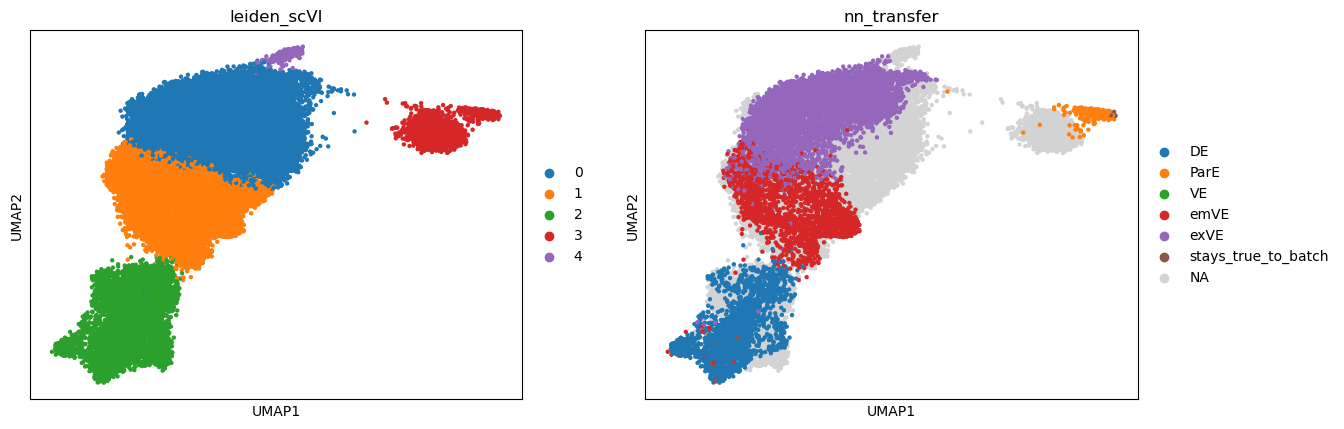

In [37]:
sc.pl.umap(adata, color = ['leiden_scVI', 'nn_transfer'], size = 40)

In [8]:
## SETTING THE CELLS THAT STAY TRUE TO BATCH 

adata.obs.loc[(adata.obs['leiden_scVI'] == '2') & (adata.obs['nn_transfer'] == 'stays_true_to_batch'), 'nn_transfer'] = 'DE'
adata.obs.loc[(adata.obs['leiden_scVI'] == '3') & (adata.obs['nn_transfer'] == 'stays_true_to_batch'), 'nn_transfer'] = 'ParE'

In [9]:
adata.obs['nn_transfer'].value_counts()

exVE                   5884
DE                     2407
emVE                   1870
ParE                    260
VE                        2
stays_true_to_batch       0
Name: nn_transfer, dtype: int64

## SAVE DATA AND MODELS 

In [10]:
data_path = '/data/hadjantalab/lucas/atlas/data/reannotation'

In [8]:
adata.obsm['X_umap'] = adata.obsm['X_umap_scVI'].copy()

In [11]:
file_path = os.path.join(data_path, 'adata_endo_cohort55-775.h5ad')
adata.write_h5ad(file_path)

In [64]:
%%time
file_path = os.path.join(data_path, "scvi/endo_cohort55-775")
model.save(file_path, overwrite = True)

CPU times: user 35 ms, sys: 8.19 ms, total: 43.2 ms
Wall time: 173 ms


In [12]:
## Save the nearest neighbor reannotation
reanno_endo_cohort55_775_nn_transfer = adata.obs['nn_transfer']
file_path = os.path.join(data_path, "reanno_endo_cohort55-775_nn-transfer.csv")
reanno_endo_cohort55_775_nn_transfer.to_csv(file_path, index=True)

## LOAD ADATA & MODEL

In [5]:
data_path = '/data/hadjantalab/lucas/atlas/data/reannotation'

In [6]:
file_path = os.path.join(data_path, 'adata_endo_cohort55-775.h5ad')
adata = ad.read_h5ad(file_path)

In [68]:
# Load the model using the custom pickle module
#file_path = os.path.join(data_path, "scvi/endo_cohort55-775")
#model = scvi.model.SCVI.load(file_path, adata)